Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ran/cs566/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ran/cs566/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ran/cs566/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
No checkpoint found, starting from scratch.


Training:   0%|          | 0/13750 [00:00<?, ?it/s]/home/ran/cs566/.venv/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:159: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splprep(x, w, u, ub, ue, k, task, s, t, full_output, nest, per,
Training:   0%|          | 5/13750 [00:00<33:21,  6.87it/s]  /home/ran/cs566/.venv/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:159: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splprep(x, w, u, ub, ue, k, task, s, t, full_output, nest, per,


Epoch [1/10]  Loss: 0.0229
LPIPS: 0.2389


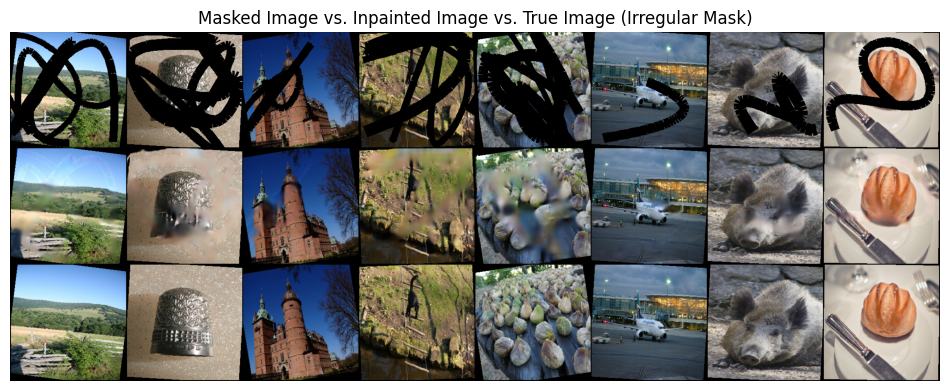

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [2/10]  Loss: 0.0192
LPIPS: 0.1790


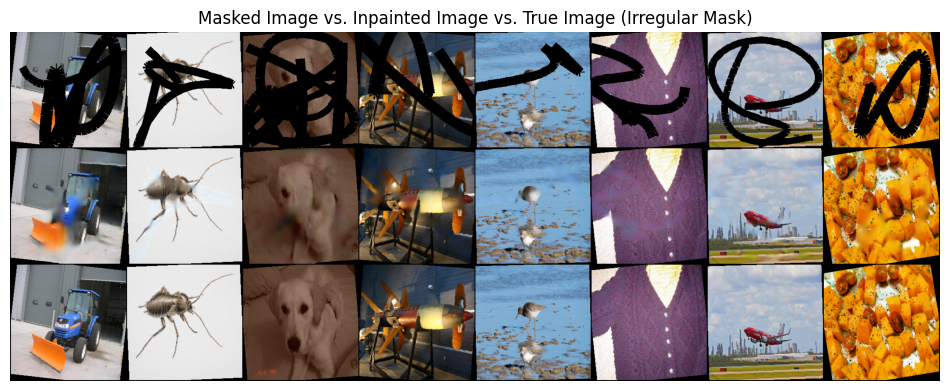

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [3/10]  Loss: 0.0183
LPIPS: 0.1863


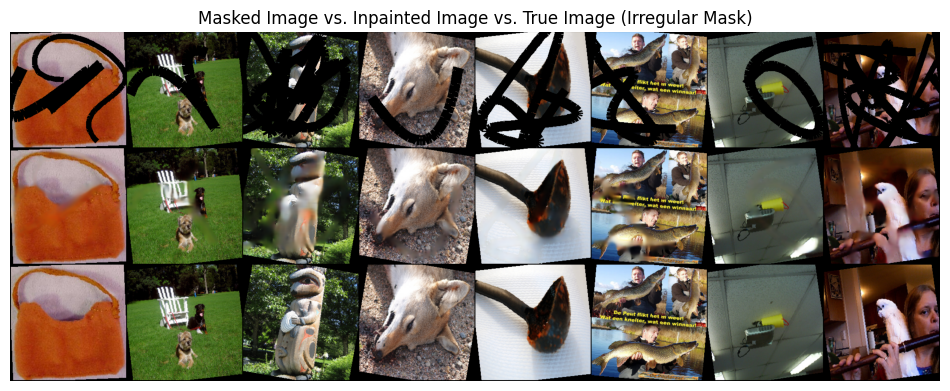

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [4/10]  Loss: 0.0178
LPIPS: 0.1866


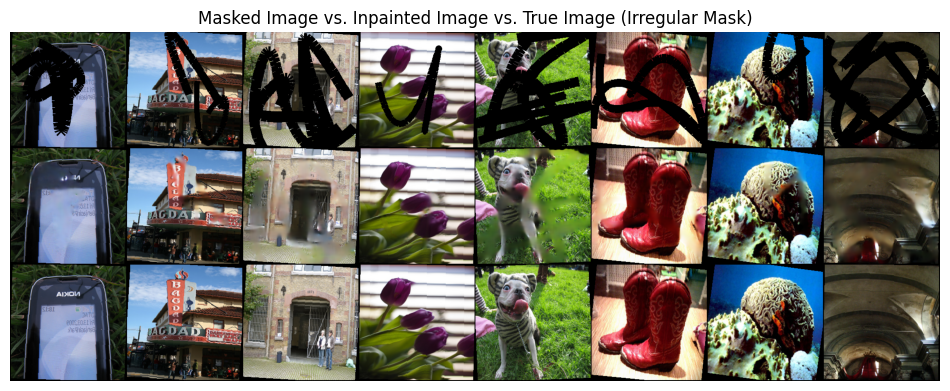

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [5/10]  Loss: 0.0175
LPIPS: 0.1472


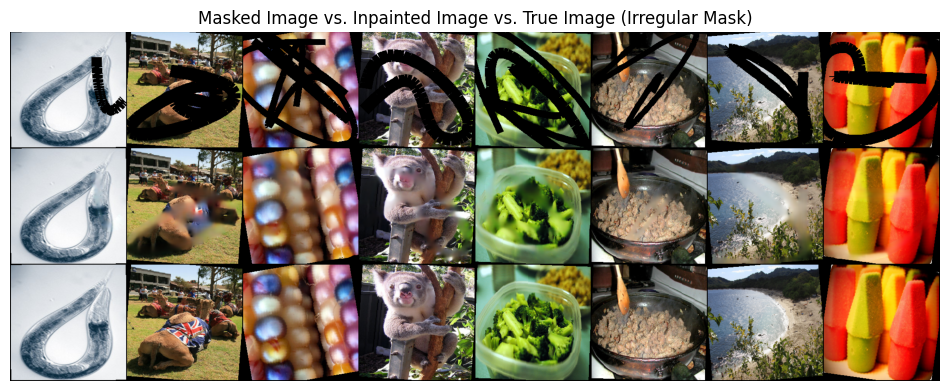

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [6/10]  Loss: 0.0172
LPIPS: 0.1643


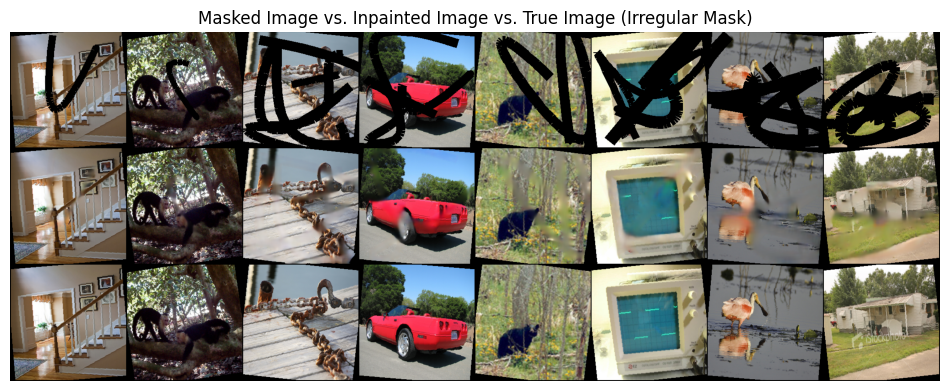

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [7/10]  Loss: 0.0170
LPIPS: 0.1671


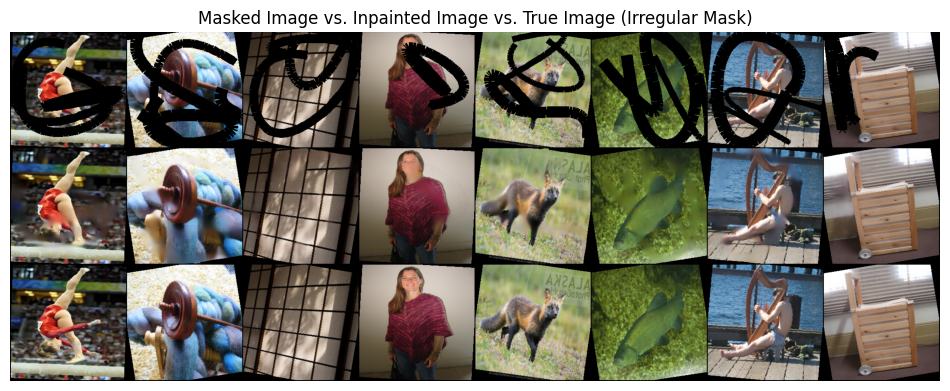

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [8/10]  Loss: 0.0169
LPIPS: 0.1917


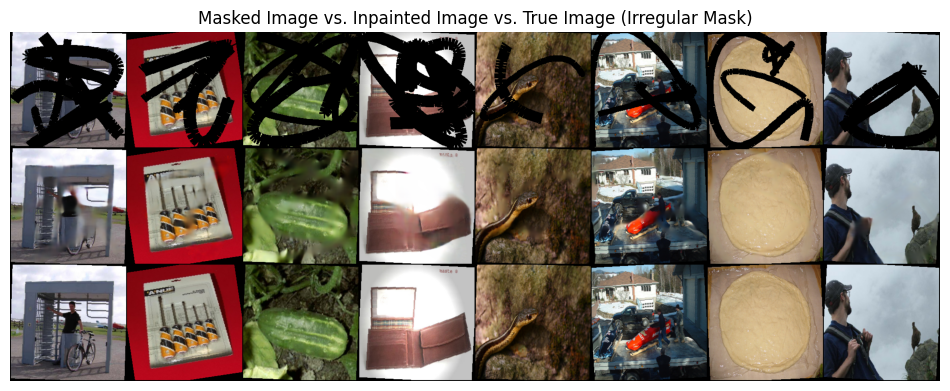

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [9/10]  Loss: 0.0168
LPIPS: 0.1437


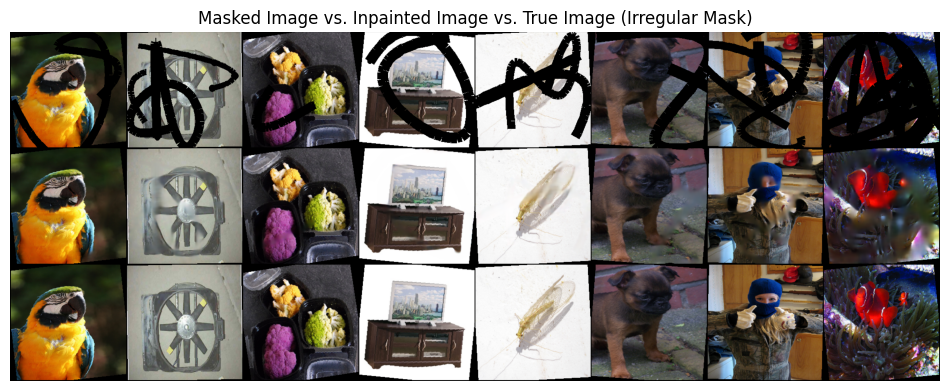

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt


Epoch [10/10]  Loss: 0.0167
LPIPS: 0.1795


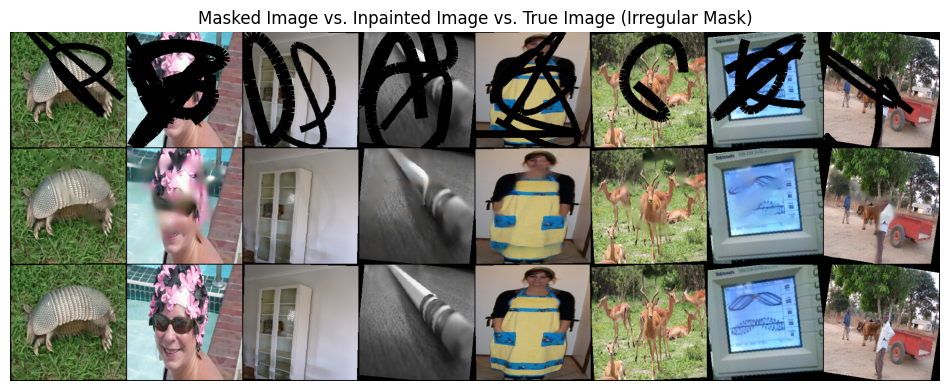

Saved checkpoint to checkpoints_100k_unet_irregular/latest.pt
Saved final UNet (irregular mask) weights to checkpoints_100k_unet_irregular/unet_irregular_inference.pth


In [ ]:
# Baseline U-Net (Irregular Mask)

DATASET_PATH = "/home/ran/cs566/large100k_sp"

import os
import random

import numpy as np
from scipy.interpolate import splprep, splev

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt
import lpips


# Irregular smooth mask 
def generate_smooth_mask(size=(256,256),
                         min_strokes=1,
                         max_strokes=3,
                         min_vertices=3,
                         max_vertices=7,
                         brush_width=(12, 28)):

    W, H = size
    mask = Image.new("L", (W, H), 255)
    draw = ImageDraw.Draw(mask)

    num_strokes = random.randint(min_strokes, max_strokes)

    for _ in range(num_strokes):

        num_vertices = random.randint(min_vertices, max_vertices)

        xs = np.random.randint(0, W, num_vertices)
        ys = np.random.randint(0, H, num_vertices)

        points = None

        if num_vertices >= 4:
            try:
                tck, _ = splprep([xs, ys], s=3, k=3)
                unew = np.linspace(0, 1, 100)
                out = splev(unew, tck)
                points = list(zip(out[0], out[1]))
            except Exception:
                points = list(zip(xs, ys))

        elif num_vertices == 3:
            try:
                tck, _ = splprep([xs, ys], s=1, k=2)
                unew = np.linspace(0, 1, 80)
                out = splev(unew, tck)
                points = list(zip(out[0], out[1]))
            except Exception:
                points = list(zip(xs, ys))

        else:
            points = list(zip(xs, ys))

        # Brush width
        w = random.randint(*brush_width)

        # Main stroke
        draw.line(points, fill=0, width=w)

        # Occasional blobs along the stroke
        if random.random() < 0.3:
            for (px, py) in points[::25]:
                r = random.randint(2, 8)
                draw.ellipse([px - r, py - r, px + r, py + r], fill=0)

    return mask

# Dataset using irregular masks
class ILSVRCInpaintDataset(Dataset):
    def __init__(self, root_dir):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.resize = transforms.Resize((256, 256))
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = self.resize(img)
        img = self.transform(img)

        # Irregular stroke-based hole
        mask = generate_smooth_mask(size=img.size)

        img_tensor = self.to_tensor(img)
        mask_tensor = (self.to_tensor(mask) > 0.5).float()  # 1 = valid, 0 = hole
        masked_t = img_tensor * mask_tensor

        sample = {"img": img_tensor, "masked": masked_t, "mask": mask_tensor}
        return sample

# Baseline U-Net (same as above)
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                )
            )
            in_channels = feature

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1] * 2, 3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1] * 2, features[-1] * 2, 3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True),
        )

        # Decoder
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature * 2, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, 3, padding=1, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                )
            )

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skips = skips[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skips[idx // 2]
            x = self.ups[idx + 1](torch.cat((skip, x), dim=1))

        x = torch.sigmoid(self.final_layer(x))
        return x

# Training epoch
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        masked = batch["masked"].to(device, non_blocking=True)
        img = batch["img"].to(device, non_blocking=True)
        mask = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad()
        pred = model(masked)
        loss = criterion(pred * (1 - mask), img * (1 - mask))
        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
    return total_loss / len(dataloader)

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ILSVRCInpaintDataset(DATASET_PATH)
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
)

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
lpips_model = lpips.LPIPS(net="vgg").to(device).eval()

epochs = 10

checkpoint_dir = "checkpoints_100k_unet_irregular"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "latest.pt")

start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path} ...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found, starting from scratch.")

for epoch in range(start_epoch, epochs):
    avg_loss = None

    try:
        avg_loss = train_epoch(model, dataloader, optimizer, criterion, device)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}")

        with torch.no_grad():
            batch = next(iter(dataloader))
            masked = batch["masked"].to(device)
            img = batch["img"].to(device)
            mask = batch["mask"].to(device)

            pred = model(masked)

            combined_inpainted_img = pred * (1 - mask) + img * mask
            combined_lp = combined_inpainted_img * 2 - 1
            img_lp = img * 2 - 1
            lpips_val = lpips_model(combined_lp, img_lp).mean().item()
            print(f"LPIPS: {lpips_val:.4f}")

            show = torch.cat([masked, combined_inpainted_img, img], dim=0)
            grid = make_grid(show.cpu(), nrow=masked.size(0), padding=2)
            plt.figure(figsize=(1.5 * masked.size(0), 6))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis("off")
            plt.title("Masked Image vs. Inpainted Image vs. True Image (Irregular Mask)")
            plt.show()

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Saved checkpoint to {checkpoint_path}")

    except KeyboardInterrupt:
        print("\nTraining interrupted by user, saving checkpoint...")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved to {checkpoint_path}. Re-run later to resume.")
        raise

    except Exception as e:
        print(f"\nError during epoch {epoch+1}: {e}")
        print("Saving checkpoint before exiting...")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved to {checkpoint_path}. Fix the issue and re-run to resume.")
        raise

# Save final weights for inference
final_model_path = os.path.join(checkpoint_dir, "unet_irregular_inference.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Saved final UNet (irregular mask) weights to {final_model_path}")
